# Packages 

In [1]:
%matplotlib inline
import os
from math import radians, cos, sin, asin, sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans 
import xgboost as xgb
from datetime import datetime  
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
from sklearn.metrics import mean_squared_log_error

In [2]:
pd.set_option('display.max_columns', 500)

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./Predict Taxi Travel Time-d65166414ba3.json"
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../Predict Taxi Travel Time-d65166414ba3.json"
from google.cloud import bigquery
client = bigquery.Client()

# Functions

In [3]:
def load_data(path) :
    data = pd.read_csv(path) 
    return (data)

def load_data_bigquery(path) :
    data = pd.read_csv(path) 
    data.loc[data.Parallel_Distance.isnull(), 'Parallel_Distance'] = data[data['Parallel_Distance'].isnull()]['distance_in_km'].values
    #basic data cleaning. drop useless columns
    data = data.drop(['date_of_year2','mo','da'], axis=1)
    return (data)


def extract_time_bigquery (data):
    data['pickup_datetime'] = pd.to_datetime(data.pickup_datetime)  
    data.loc[:,'pickup_day'] =  data['pickup_datetime'].dt.day
    data.loc[:,'pickup_month'] =  data['pickup_datetime'].dt.month
    data.loc[:,'pickup_hour'] =  data['pickup_datetime'].dt.hour
    data.loc[:,'pickup_weekday'] =  data['pickup_datetime'].dt.weekday+1
    data.loc[:,'log_travel_time'] =  np.log(data['travel_time'].values+1)
    
    return(data)

def extract_time (data):
    data['pickup_datetime'] = pd.to_datetime(data.pickup_datetime)  
    data.loc[:,'pickup_day'] =  data['pickup_datetime'].dt.day
    data.loc[:,'pickup_month'] =  data['pickup_datetime'].dt.month
    data.loc[:,'pickup_hour'] =  data['pickup_datetime'].dt.hour
    data.loc[:,'pickup_weekday'] =  data['pickup_datetime'].dt.weekday+1
    return (data)

def add_avg_speed(data, group,name) :
    avg_speed = pd.DataFrame(data.groupby(group)['speed'].mean())
    avg_speed = avg_speed.rename(columns={'speed':name})
    return (avg_speed)


def ifef(col):
    col = str(col)
    if col in Holiday_1:
        return  'common_holiday'
    if col in Holiday_2:
        return 'key_holiday'
    else:
        return 0
    
# Transfrom categorical variables into dummy variables using one hot encode
def dummy_one_hot_bigquery (data):
    passenger_count = pd.get_dummies(data['passenger_count'], prefix='pc', prefix_sep='_')  
    cluster_pickup = pd.get_dummies(data['pickup_cluster'], prefix='p', prefix_sep='_')  
    cluster_dropoff = pd.get_dummies(data['dropoff_cluster'], prefix='d', prefix_sep='_')  
    #month = pd.get_dummies(data['pickup_month'], prefix='m', prefix_sep='_')   
    dom = pd.get_dummies(data['pickup_day'], prefix='dom', prefix_sep='_')  
    hour = pd.get_dummies(data['pickup_hour'], prefix='h', prefix_sep='_')  
    dow = pd.get_dummies(data['pickup_weekday'], prefix='dow', prefix_sep='_')  
    # drop unnecessary variables
    data = data.drop(['passenger_count','pickup_month','pickup_day','pickup_hour','pickup_weekday',  
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','pickup_datetime', 
                              'trip_distance','speed','travel_time','date_of_year'], axis=1)
    # merge dummy variables to the origin dataset
    data = pd.concat([data,  
                          passenger_count,
                          cluster_pickup,
                          cluster_dropoff,
                          dom, hour, dow], axis=1)
    
    return(data)

def dummy_one_hot (data):
    passenger_count = pd.get_dummies(data['passenger_count'], prefix='pc', prefix_sep='_')  
    cluster_pickup = pd.get_dummies(data['pickup_cluster'], prefix='p', prefix_sep='_')  
    cluster_dropoff = pd.get_dummies(data['dropoff_cluster'], prefix='d', prefix_sep='_')  
    #month = pd.get_dummies(data['pickup_month'], prefix='m', prefix_sep='_')   
    dom = pd.get_dummies(data['pickup_day'], prefix='dom', prefix_sep='_')  
    hour = pd.get_dummies(data['pickup_hour'], prefix='h', prefix_sep='_')  
    dow = pd.get_dummies(data['pickup_weekday'], prefix='dow', prefix_sep='_')  
    # drop unnecessary variables
    data = data.drop(['passenger_count','pickup_month','pickup_day','pickup_hour','pickup_weekday',  
                   'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','pickup_datetime'
                      ,'date_of_year2','mo','da','date_of_year'
                              ], axis=1)
    # merge dummy variables to the origin dataset
    data = pd.concat([data,  
                          passenger_count,
                          cluster_pickup,
                          cluster_dropoff,
                          #month,
                          dom, hour, dow], axis=1)
    
    return(data)

def col_consistant(data,cluster_num):
    cluster = range(1,cluster_num,1)
    cluster_dummy_p = pd.get_dummies(cluster, prefix='p', prefix_sep='_')  
    cluster_dummy_d = pd.get_dummies(cluster, prefix='d', prefix_sep='_')  
    cluster_dummy = pd.concat([cluster_dummy_p, cluster_dummy_d], axis=1)
    passenger = range(1,9,1)
    passenger_dummy = pd.get_dummies(passenger, prefix='pc', prefix_sep='_') 
    whole = pd.concat([cluster_dummy, passenger_dummy], axis=1)
    larger_colnames = whole.columns.values.tolist()
    smaller_colnames = data.columns.values.tolist()
    ret = list(set(larger_colnames).difference(set(smaller_colnames)))
    d = pd.DataFrame(0, index=np.arange(data.shape[0]), columns=ret)
    data = pd.concat([data,  
                          d], axis=1)
    return(data)

# Load data

In [4]:
# weather
query = (
    """
     select concat(year,'-',mo,'-',da) as date_of_year2,year,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
     from `bigquery-public-data.noaa_gsod.gsod2015` 
     WHERE stn='725053' AND CAST(year AS STRING)='2015'
     ORDER BY date_of_year2
    """
)
weather_2015=pd.io.gbq.read_gbq(query,dialect='standard')

#weather_2015.to_csv("test_results.csv", index=False)  

In [5]:
# # load test data
# query = (
#     """
#     CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
#         ACOS(-1) * x / 180
#     );
#     CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
#         111.045 * 180 * x / ACOS(-1)
#     );
#     CREATE TEMP FUNCTION VALID_ACOS(x FLOAT64) RETURNS FLOAT64 AS (
#         CASE
#             WHEN x <=1 and x>=-1 THEN ACOS(x)
#             ELSE NULL
#           END
#     );
#     CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
#                                lat2 FLOAT64, long2 FLOAT64) AS (
#         RADIANS_TO_KM(
#             VALID_ACOS(COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
#             COS(RADIANS(long1) - RADIANS(long2)) +
#             SIN(RADIANS(lat1)) * SIN(RADIANS(lat2))))
#     );
#     CREATE TEMP FUNCTION PARALLEL_DISTANCE(lat1 FLOAT64, long1 FLOAT64,
#                                lat2 FLOAT64, long2 FLOAT64) AS (
#         HAVERSINE(lat1, long1, lat1, long2) +
#         HAVERSINE(lat1, long1, lat2, long1)
#     );
#      CREATE TEMP FUNCTION TO_PEN_DISTANCE(lat FLOAT64, long FLOAT64) AS (
#         HAVERSINE(lat, long, 40.751, -73.994)
#     );
#     CREATE TEMP FUNCTION TO_LAG_DISTANCE(lat FLOAT64, long FLOAT64) AS (
#         HAVERSINE(lat, long, 40.774, -73.873)
#     );
#     CREATE TEMP FUNCTION TO_JFK_DISTANCE(lat FLOAT64, long FLOAT64) AS (
#         HAVERSINE(lat, long, 40.645, -73.782)
#     );
#     CREATE TEMP FUNCTION TO_CSMK_DISTANCE(lat FLOAT64, long FLOAT64) AS (
#         HAVERSINE(lat, long, 40.743, -74.006)
#     );
#     CREATE TEMP FUNCTION TO_MMOA_DISTANCE(lat FLOAT64, long FLOAT64) AS (
#         HAVERSINE(lat, long, 40.779, -73.962)
#     );
   

#     SELECT 
#                     EXTRACT (DATE FROM pickup_datetime) as date_of_year,
#                     pickup_datetime,
#                     TIMESTAMP_DIFF(dropoff_datetime,pickup_datetime,SECOND) AS travel_time,
#                     trip_distance,
#                     pickup_latitude,
#                     pickup_longitude,
#                     dropoff_latitude,
#                     dropoff_longitude,
#                     passenger_count,
#                     HAVERSINE(dropoff_latitude,dropoff_longitude, pickup_latitude, pickup_longitude) AS distance_in_km,
#                     PARALLEL_DISTANCE(dropoff_latitude,dropoff_longitude, pickup_latitude, pickup_longitude) AS Parallel_Distance,
#                     TO_PEN_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_PEN_DISTANCE,
#                     TO_LAG_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_LAG_DISTANCE,
#                     TO_JFK_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_JFK_DISTANCE,
#                     TO_CSMK_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_CSMK_DISTANCE,
#                     TO_MMOA_DISTANCE(dropoff_latitude, dropoff_longitude) AS drop_MMOA_DISTANCE,
#                     TO_PEN_DISTANCE(pickup_latitude, pickup_longitude) AS pick_PEN_DISTANCE,
#                     TO_LAG_DISTANCE(pickup_latitude, pickup_longitude) AS pick_LAG_DISTANCE,
#                     TO_JFK_DISTANCE(pickup_latitude, pickup_longitude) AS pick_JFK_DISTANCE,
#                     TO_CSMK_DISTANCE(pickup_latitude, pickup_longitude) AS pick_CSMK_DISTANCE,
#                     TO_MMOA_DISTANCE(pickup_latitude, pickup_longitude) AS pick_MMOA_DISTANCE
#     FROM `predict-taxi-travel-time.nyc_taxi.final_test_filtered`
#   
#     
#  """)
# test_results=pd.io.gbq.read_gbq(query,dialect='standard')
# test_results.to_csv("test_results.csv", index=False)  

In [6]:
# load S&P 500 data
path = "GSPC_2015.csv"
stock_2015 = load_data(path)

# load training data
path = "train_data_135_filtered.csv"
taxi_data = load_data_bigquery(path)

# load test data
path = "test_results.csv"
test_data = load_data(path)
#test_y = test_results['travel_time']
#test_data = test_results.drop(['travel_time','trip_distance'],axis = 1)

# holiday data in 2015
Holiday_2 = ['2015-01-01', '2015-01-19', '2015-02-14', '2015-04-05', '2015-04-06', '2015-07-04','2015-09-07', 
             '2015-10-31', '2015-11-26', '2015-11-27', '2015-12-24', '2015-12-25', '2015-12-31']
Holiday_1 = ['2015-01-24', '2015-02-02', '2015-02-17', '2015-03-08', '2015-03-17', '2015-04-01','2015-04-03', 
             '2015-04-22', '2015-05-05', '2015-05-10', '2015-05-16', '2015-05-24', '2015-05-25', 
             '2015-06-14', '2015-06-21', '2015-07-26', '2015-09-11', '2015-09-16', '2015-09-17', '2015-09-25',
             '2015-10-12', '2015-10-16', '2015-10-17', '2015-11-01', '2015-11-11', '2015-11-30', '2015-12-07']

# Step1. EDA for training data and testing data

## 1.1 Add more features into the dataset

In [7]:
# add time feature to the model
## train
taxi_data = extract_time_bigquery(taxi_data)
## test
test_data = extract_time(test_data)

## 1.2 Passenger count

Text(0.5,1,'Traning dataset ')

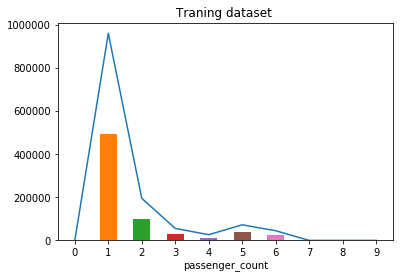

In [8]:
# calculate number of pickups by passenger count
#testing
test_data.groupby(['passenger_count'])['pickup_datetime'].count().plot(kind = "bar")
plt.xlabel('passenger_count')
plt.title('Testing dataset ')
# training
taxi_data.groupby(['passenger_count'])['pickup_datetime'].count().plot()
plt.xlabel('passenger_count')
plt.title('Traning dataset ')


The distribution is quite similar.

## 1.3 Pickup time

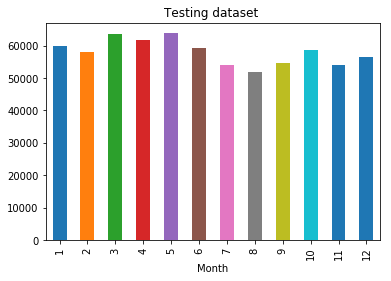

Text(0.5,1,'Traning dataset ')

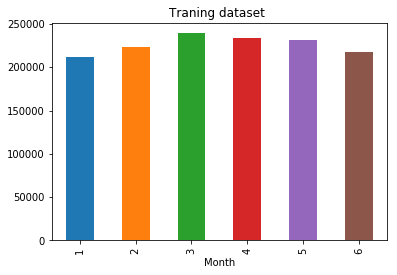

In [9]:
# calculate number of pickups by passenger count
#testing
test_data.groupby(['pickup_month'])['pickup_datetime'].count().plot(kind = "bar")
plt.xlabel('Month')
plt.title('Testing dataset ')
plt.show()
# training
taxi_data.groupby(['pickup_month'])['pickup_datetime'].count().plot(kind = "bar")
plt.xlabel('Month')
plt.title('Traning dataset ')

## 1.4 Pickup&Dropoff location

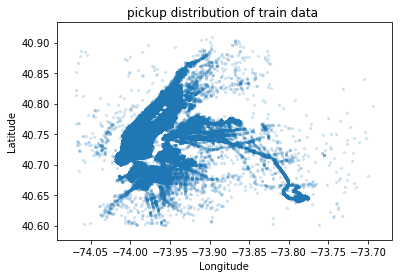

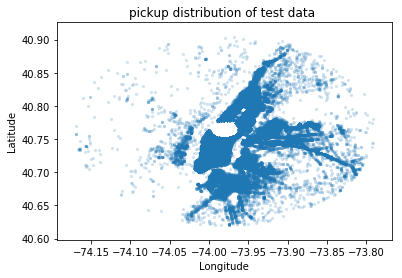

In [10]:
# pickup distribution of train data 
plt.scatter(taxi_data.pickup_longitude.values, taxi_data.pickup_latitude.values, s=10, lw=0,  
            cmap='autumn', alpha=0.2)
#city_long_border = (-74.03, -73.75)  
#city_lat_border = (40.63, 40.85)  
#plt.xlim(city_long_border)  
#plt.ylim(city_lat_border)  
plt.xlabel('Longitude')  
plt.ylabel('Latitude')  
plt.title('pickup distribution of train data ')  
plt.show()  
# pickup distribution of test data 
plt.scatter(test_data.pickup_longitude.values, test_data.pickup_latitude.values, s=10, lw=0,  
            cmap='autumn', alpha=0.2)
#city_long_border = (-74.03, -73.75)  
#city_lat_border = (40.63, 40.85)  
#plt.xlim(city_long_border)  
#plt.ylim(city_lat_border)  
plt.xlabel('Longitude')  
plt.ylabel('Latitude')  
plt.title('pickup distribution of test data ')  
plt.show()  

The distribution is similar different but the test data lost the recodes in midtown.

# Step2 Add outside dataset

## 2.1 Add Weather and S&P 500

In [11]:
# merge stock data with weather
stock_logrtn_2015 = {'Date': stock_2015[1:]["Date"].values  
                ,"logrtn" : np.log(stock_2015[1:]["Adj_Close"].values/stock_2015[0:-1]["Adj_Close"].values)*100 }
stock_logrtn_2015 = pd.DataFrame(stock_logrtn_2015)
weather_stock_2015 = pd.merge(weather_2015,
             stock_logrtn_2015[["Date","logrtn"]],
             left_on = "date_of_year2",
             right_on = "Date",
             how = "left"
            )
weather_stock_2015['logrtn'].fillna(0, inplace=True)
weather_stock_2015 = weather_stock_2015.drop(['Date', 'year'], axis = 1)
weather_stock_2015.head()

,date_of_year2,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,logrtn
0,2015-01-01,01,01,31.4,10.0,5.3,25.1,39.0,27.0,0.00,999.9,0,0,0,0,0,0.000000
1,2015-01-02,01,02,38.7,10.0,7.0,20.0,42.1,27.0,0.00,999.9,0,0,0,0,0,-0.034002
2,2015-01-03,01,03,35.5,7.6,5.0,14.0,42.1,33.1,0.00,999.9,0,1,1,0,0,0.000000
3,2015-01-04,01,04,45.4,5.8,5.1,19.0,55.9,33.1,0.89,999.9,0,1,0,0,0,0.000000
4,2015-01-05,01,05,40.9,9.7,9.7,40.0,55.9,28.9,0.12,999.9,0,1,0,0,0,-1.844721


## 2.2 Add holidays

In [12]:
weather_stock_2015['holiday'] = weather_stock_2015['date_of_year2'].apply(ifef)
df_holiday = pd.get_dummies(weather_stock_2015['holiday'])
weather_stock_2015 = weather_stock_2015.join(df_holiday)
features = weather_stock_2015.drop(['holiday',0] ,axis=1)

features.head()

,date_of_year2,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,logrtn,common_holiday,key_holiday
0,2015-01-01,01,01,31.4,10.0,5.3,25.1,39.0,27.0,0.00,999.9,0,0,0,0,0,0.000000,0,1
1,2015-01-02,01,02,38.7,10.0,7.0,20.0,42.1,27.0,0.00,999.9,0,0,0,0,0,-0.034002,0,0
2,2015-01-03,01,03,35.5,7.6,5.0,14.0,42.1,33.1,0.00,999.9,0,1,1,0,0,0.000000,0,0
3,2015-01-04,01,04,45.4,5.8,5.1,19.0,55.9,33.1,0.89,999.9,0,1,0,0,0,0.000000,0,0
4,2015-01-05,01,05,40.9,9.7,9.7,40.0,55.9,28.9,0.12,999.9,0,1,0,0,0,-1.844721,0,0


## 2.3 Merge new features to test dataset

In [13]:
test_merge = pd.merge(test_data,features
                      , left_on = "date_of_year"
                      , right_on = "date_of_year2"
                      ,how = "left")

In [14]:
def string_to_int(test_merge):
    test_merge['wdsp'] = test_merge['wdsp'].astype('float')
    test_merge['fog'] = test_merge['fog'].astype('float')
    test_merge['rain_drizzle'] = test_merge['rain_drizzle'].astype('int')
    test_merge['snow_ice_pellets'] = test_merge['snow_ice_pellets'].astype('int')
    test_merge['hail'] = test_merge['hail'].astype('int')
    test_merge['thunder'] = test_merge['thunder'].astype('int')
    return (test_merge)

test_merge = string_to_int(test_merge)

# Step3 Using K-Means to cluster the pickup & dropoff locations

We will use **MiniBatchKMeans** function to cluster pickup&dropoff location into 500 categories.

In [15]:
# pickup = taxi_data[['pickup_latitude', 'pickup_longitude']].append(test_merge[['pickup_latitude', 'pickup_longitude']])
# dropoff = taxi_data[['dropoff_latitude', 'dropoff_longitude']].append(test_merge[['dropoff_latitude', 'dropoff_longitude']])
#coords = np.vstack((pickup.values,  dropoff.values))
coords = np.vstack((taxi_data[['pickup_latitude', 'pickup_longitude']].values,  taxi_data[['dropoff_latitude', 'dropoff_longitude']].values))
# cluster pickup&dropoff location into 500 categories
kmeans = MiniBatchKMeans(n_clusters=500, batch_size=10000).fit(coords)  
# calculte cluster in train dataset
taxi_data.loc[:, 'pickup_cluster'] = kmeans.predict(taxi_data[['pickup_latitude', 'pickup_longitude']])  
taxi_data.loc[:, 'dropoff_cluster'] = kmeans.predict(taxi_data[['dropoff_latitude', 'dropoff_longitude']])  
# calculte cluster in test dataset
test_merge.loc[:, 'pickup_cluster'] = kmeans.predict(test_merge[['pickup_latitude', 'pickup_longitude']])  
test_merge.loc[:, 'dropoff_cluster'] = kmeans.predict(test_merge[['dropoff_latitude', 'dropoff_longitude']])  

# Step4 Convert categorical variables into dummy variables using one hot encode

drop unnecessary columns

In [17]:
# Transfrom categorical variables into dummy variables using one hot encode
taxi_data_dummy = dummy_one_hot_bigquery(taxi_data)
# let testing data and training data has the same columns 
taxi_data_final = col_consistant(taxi_data_dummy,500)
# Transfrom categorical variables into dummy variables using one hot encode
test_dummy = dummy_one_hot(test_merge)
test_final = col_consistant(test_dummy,500)
test_final = test_final[taxi_data_final.drop(['log_travel_time'],axis=1).columns.values.tolist()]

# Step5 Using XGBoost to build model

## 5.1 Split data into train and test data

In [19]:
train, test  = train_test_split(taxi_data_final,test_size=0.8, random_state=535)
# train and test dataset for the XGBoost model
X_train = train.drop(['log_travel_time'], axis=1)  
Y_train = train["log_travel_time"]  
X_test = test.drop(['log_travel_time'], axis=1)  
Y_test = test["log_travel_time"]

Y_test = Y_test.reset_index().drop('index',axis = 1)  
Y_train = Y_train.reset_index().drop('index',axis = 1)  

## 5.2 Transfrom data into the format that suit for XGBoost 

In [20]:
# Transfrom training data and testing data into the format that suit for XGBoost 
dtrain = xgb.DMatrix(X_train, label=Y_train)  
dvalid = xgb.DMatrix(X_test, label=Y_test)  
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]  
dtest = xgb.DMatrix(test_final)

## 5.3 Build XGBoost model

In [22]:
xgb_pars = {'min_child_weight': 33, 'eta': 0.3, 'colsample_bytree': 0.9, 
                       'max_depth': 7,
                       'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
                       'eval_metric': 'rmse', 'objective': 'reg:linear'}
xgb_model = xgb.train(xgb_pars, dtrain, 120, watchlist, early_stopping_rounds=10,
                 maximize=False, verbose_eval=10)

[0]	train-rmse:4.22065	valid-rmse:4.22297
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[10]	train-rmse:0.421771	valid-rmse:0.424969
[20]	train-rmse:0.379068	valid-rmse:0.384376
[30]	train-rmse:0.368294	valid-rmse:0.37559
[40]	train-rmse:0.361229	valid-rmse:0.370324
[50]	train-rmse:0.357182	valid-rmse:0.367573
[60]	train-rmse:0.354106	valid-rmse:0.3662
[70]	train-rmse:0.34786	valid-rmse:0.361941
[80]	train-rmse:0.344305	valid-rmse:0.361064
[90]	train-rmse:0.33962	valid-rmse:0.358349
[100]	train-rmse:0.337232	valid-rmse:0.357516
[110]	train-rmse:0.335392	valid-rmse:0.356892
[119]	train-rmse:0.333289	valid-rmse:0.3563


## 5.4 Feature importance plots

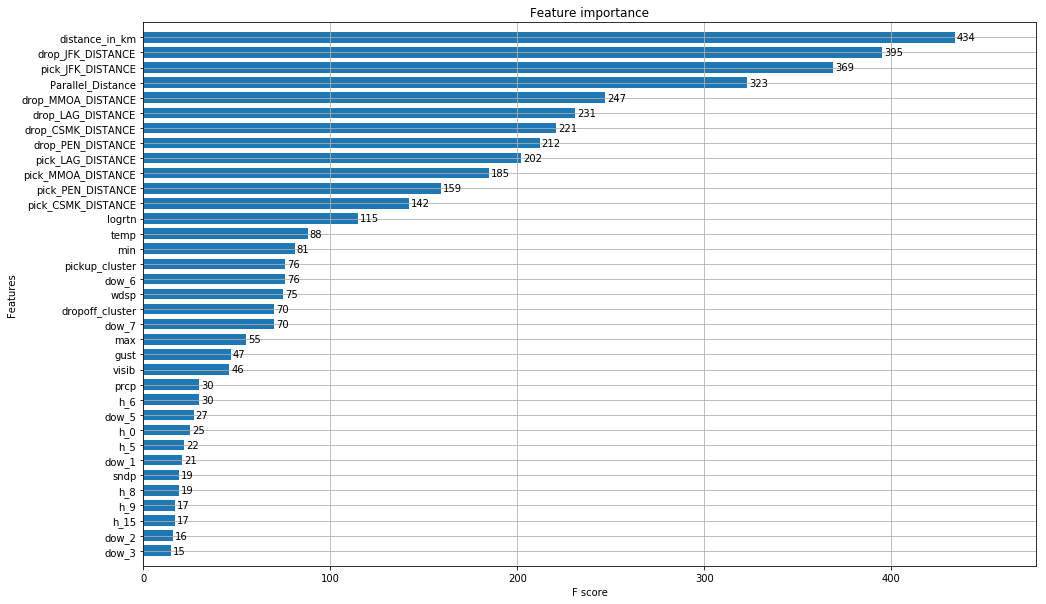

In [25]:
plt.rcParams['figure.figsize'] = [16, 10]
xgb.plot_importance(xgb_model, max_num_features=35, height=0.7)

## 5.5 Predict

In [26]:
# prediction and submission
pred = xgb_model.predict(dtest)  
pred = np.exp(pred)-1 


# Step6 Submission

In [35]:
submission = pd.concat([test_data, pd.DataFrame(pred)], axis=1) 
submission = submission.rename(columns = {0:'predictions'})
submission.to_csv("submission.csv", index=False)  